In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)

In [2]:
diabetes = load_diabetes()

In [3]:
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['Target']=diabetes.target

(array([38., 80., 68., 62., 50., 41., 38., 42., 17.,  6.]),
 array([ 25. ,  57.1,  89.2, 121.3, 153.4, 185.5, 217.6, 249.7, 281.8,
        313.9, 346. ]),
 <BarContainer object of 10 artists>)

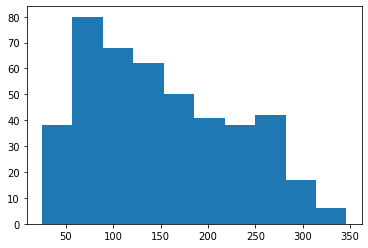

In [4]:
plt.hist(df['Target'])

In [5]:
df['Target'].min()
df['Target'].max()

346.0

In [6]:
# 무작위 섞기
df=df.iloc[np.random.permutation(df.index)].reset_index(drop=True)

In [7]:
# 학습용 데이터, 시험용 데이터 분리
train_df = df.copy()[:-20]
test_df = df.copy()[-20:]

In [8]:
print(f'학습 데이터 차원: {train_df.shape}')
print(f'시험 데이터 차원: {test_df.shape}')

학습 데이터 차원: (422, 11)
시험 데이터 차원: (20, 11)


In [9]:
# 데이터 전처리 - {데이터,레이블} 모든 열에 대해 정규화 작업
data_processing = {} # 후처리를 위한 원래 데이터의 min-max값 저장
for idx,head in enumerate(train_df.columns):
    data_processing[head] = [train_df[head].min(),train_df[head].max()]

In [10]:
data_processing

{'age': [-0.107225631607358, 0.110726675453815],
 'sex': [-0.044641636506989, 0.0506801187398187],
 'bmi': [-0.0902752958985185, 0.17055522598066],
 'bp': [-0.112399602060758, 0.132044217194516],
 's1': [-0.126780669916514, 0.153913713156516],
 's2': [-0.115613065979398, 0.198787989657293],
 's3': [-0.10230705051742, 0.181179060397284],
 's4': [-0.076394503750001, 0.185234443260194],
 's5': [-0.126097385560409, 0.133598980013008],
 's6': [-0.137767225690012, 0.135611830689079],
 'Target': [25.0, 346.0]}

In [11]:
def input_preprocessing(x,data_processing):
    for idx,(key,value) in enumerate(data_processing.items()):
        if idx >= x.shape[1]:
            break
        x[:,idx] = (x[:,idx]-value[0])/(value[1]-value[0])
    return x

def label_preprocessing(y,data_preprocessing):
    return (y-data_processing['Target'][0])/(data_processing['Target'][1]-data_processing['Target'][0])

def output_postprocessing(y,data_processing):
    y = y*(data_processing['Target'][1]-data_processing['Target'][0])+data_processing['Target'][0]
    return y

In [12]:
train_np = train_df.to_numpy()
train_x, train_y = train_np[:,:-1], train_np[:,-1].reshape(-1,1)

In [13]:
pre_trainx = input_preprocessing(train_x,data_processing)
pre_trainy = label_preprocessing(train_y,data_processing)
train_x = torch.Tensor(pre_trainx)
train_y = torch.Tensor(pre_trainy)
datasets = TensorDataset(train_x,train_y)

In [14]:
train_dataloader = DataLoader(datasets,batch_size=32,shuffle=True,drop_last=False)

In [15]:
# 인공신경망 모델생성
class Diabetes_model(nn.Module):
    def __init__(self):
        super(Diabetes_model,self).__init__()
        self.lin1 = nn.Linear(10,35)
        self.lin2 = nn.Linear(35,20)
        self.lin3 = nn.Linear(20,1)
    
    def forward(self,x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [16]:
model = Diabetes_model()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [17]:
L2_loss = nn.MSELoss()

In [18]:
for epoch in range(5):
    print(f'Epoch: {epoch+1}')  
    loss_buffer = []
    for idx,(x,y) in enumerate(train_dataloader):
        y_infer = model(x)
        loss = L2_loss(y_infer,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_buffer.append(loss.item())
        
        if idx % 5 == 0:
            print(f' Iteration:{idx}  Train loss {np.mean(loss_buffer):.3f}')

Epoch: 1
 Iteration:0  Train loss 0.314
 Iteration:5  Train loss 0.184
 Iteration:10  Train loss 0.135
Epoch: 2
 Iteration:0  Train loss 0.064
 Iteration:5  Train loss 0.060
 Iteration:10  Train loss 0.056
Epoch: 3
 Iteration:0  Train loss 0.047
 Iteration:5  Train loss 0.044
 Iteration:10  Train loss 0.043
Epoch: 4
 Iteration:0  Train loss 0.044
 Iteration:5  Train loss 0.045
 Iteration:10  Train loss 0.041
Epoch: 5
 Iteration:0  Train loss 0.042
 Iteration:5  Train loss 0.035
 Iteration:10  Train loss 0.033


In [19]:
test_np = test_df.to_numpy()
test_x, test_y = torch.Tensor(test_np[:,:-1]), torch.Tensor(test_np[:,-1].reshape(-1,1))
pre_testx = input_preprocessing(test_x,data_processing)
pre_testy = label_preprocessing(test_y,data_processing)

y_infer = model(pre_testx)
y_infer = output_postprocessing(y_infer,data_processing)

In [20]:
diff = []
for idx in range(len(test_np)):
    diff.append(np.abs(y_infer[idx].detach().cpu().item()-test_y[idx].detach().cpu().item()))
print(f'최대 차이: {np.max(diff)}, 번호: {np.argmax(diff)}')
print(f'최소 차이: {np.min(diff)}. 번호: {np.argmin(diff)}')
print(f'평균 차이: {np.mean(diff)}')

최대 차이: 116.67189025878906, 번호: 16
최소 차이: 1.29071044921875. 번호: 11
평균 차이: 51.423791122436526


(array([3., 5., 1., 1., 1., 2., 2., 2., 1., 2.]),
 array([  1.29071045,  12.82882843,  24.36694641,  35.90506439,
         47.44318237,  58.98130035,  70.51941833,  82.05753632,
         93.5956543 , 105.13377228, 116.67189026]),
 <BarContainer object of 10 artists>)

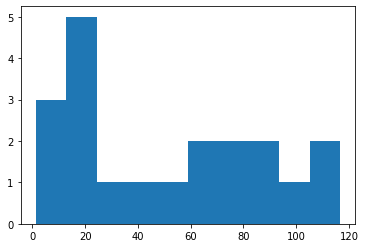

In [21]:
plt.hist(diff,bins=10)

In [23]:
idx = 11
print(f'추론값: {y_infer[idx].item()}')
print(f'실제값: {test_y[idx].item()}')

추론값: 241.70928955078125
실제값: 243.0
